In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients

In [2]:
path = "F:\JupyterNotebook_Dir\REAM _Lab\CCPP\CCPP\Folds5x2_pp.xlsx"
data = pd.read_excel(path)



data_AT = data["AT"].values;data_V = data["V"].values
data_AP = data["AP"].values;data_RH = data["RH"];data_PE = data["PE"].values
data=np.vstack((data_AT,data_V,data_AP,data_RH))
data=data.T





# Lasso Regression

In [3]:
#data_PE=data_PE.T
X_train, X_test, y_train, y_test = train_test_split(data, data_PE, test_size=0.33)

lasso = Lasso(alpha = 0.1)
lasso.fit(X_train, y_train)
print(lasso.score(X_train, y_train))
print(lasso.score(X_test, y_test))

0.9278223669307565
0.9303643674437992


Text(0.5, 1.0, 'Lasso Regression')

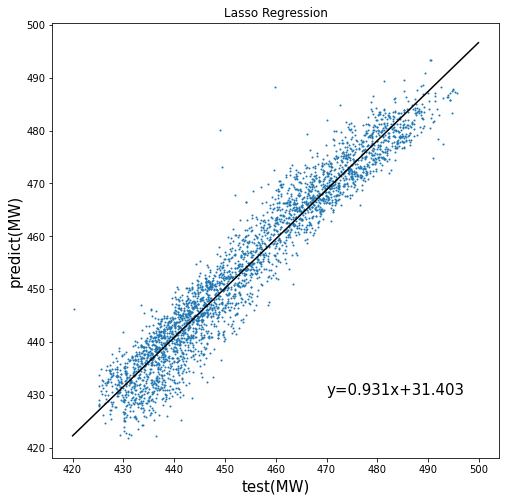

In [4]:
predict = lasso.predict(X_test)
n=len(predict)

t = np.linspace(1,n,n)
plt.figure(figsize=(8,8))
plt.xlabel('test(MW)',fontsize=15)
plt.ylabel('predict(MW)',fontsize=15)
plt.scatter(y_test,predict,s=1)
z5 = np.polyfit(y_test,predict,1)  #Linear fitting
x5 = np.arange(420, 500, 0.1)
y5 = x5 * z5[0]+z5[1]
plt.plot(x5, y5,'black')
plt.text(470,430,'y=%.3fx+%.3f'%(z5[0],z5[1]),fontsize=15)
plt.title('Lasso Regression')

# FGS attack on Lasso Regression

![Lasso](./Lasso.png)

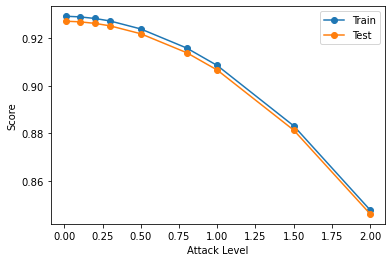

In [5]:
X = data
y = data_PE
theta = lasso.coef_
theta_lasso = theta

grad = (X@theta-y).reshape(-1,1)*theta.reshape(1,-1)
sign = np.sign(grad)

train_scores_lasso = []
test_scores_lasso = []
levels = [0.01,0.10, 0.20, 0.30, 0.50, 0.8, 1.00, 1.5, 2.0]
for level in levels:
    X_attack = X + sign * level
    X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_attack, y, test_size=0.33, random_state=42)
    train_scores_lasso.append(lasso.score(X_train_lasso, y_train_lasso))
    test_scores_lasso.append(lasso.score(X_test_lasso, y_test_lasso))

plt.plot(levels, train_scores_lasso, label="Train", marker='o');
plt.plot(levels, test_scores_lasso, label="Test", marker='o');
plt.xlabel("Attack Level");
plt.ylabel("Score");
plt.legend();

# PCA defense

In [6]:
class Model_pca(torch.nn.Module):
    def __init__(self):
        super(Model_pca,self).__init__()
        self.linear1 = torch.nn.Linear(3,12) 
        self.linear2 = torch.nn.Linear(12,8)
        self.predict = torch.nn.Linear(8,1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out =self.predict(out)
        return out
    

model_pca = Model_pca().double()
model_pca_svr = Model_pca().double()

model_pca_svr

Model_pca(
  (linear1): Linear(in_features=3, out_features=12, bias=True)
  (linear2): Linear(in_features=12, out_features=8, bias=True)
  (predict): Linear(in_features=8, out_features=1, bias=True)
)

In [7]:
#data pre-processing
scaler = StandardScaler()
data_standard = scaler.fit_transform(data)

#data_PE=data_PE.T
X_train, X_test, y_train, y_test = train_test_split(data_standard, data_PE, test_size=0.33)

x_ts=torch.from_numpy(X_train)
y_ts=torch.from_numpy(y_train)
x_test_ts=torch.from_numpy(X_test)
y_test_ts=torch.from_numpy(y_test)
y_ts=y_ts.reshape(6410,1)
y_test_ts = y_test_ts.reshape(3158,1)
x=Variable(x_ts)

In [8]:
def train_model_pca(x_train,model):
    pca = PCA(n_components=3)

    pca.fit(X_train)
    x_tr_pca = pca.fit_transform(X_train)
    x_tr_pca=torch.from_numpy(x_tr_pca)
    
    optimizer = torch.optim.SGD(model.parameters(),lr = 1e-5)
    loss_func = torch.nn.MSELoss()

    h_list = []
    l_list = []
    for epoch in range(9000):
        # forward
        y_pred = model_pca(x_tr_pca)
        loss = loss_func(y_pred,y_ts)
       # print(epoch, loss.item())
        h_list.append(epoch)
        l_list.append(loss.item())
    
        # back propagation
        optimizer.zero_grad()
        loss.backward()
    
        # updating parameters
        optimizer.step()
    return h_list,l_list,model,x_tr_pca
    
[h_list_pca,l_list_pca,model_pca,x_tr_pca]=train_model_pca(X_train,model_pca)

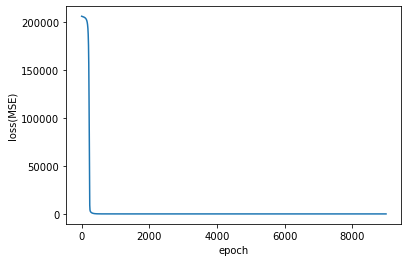

In [9]:
plt.plot(h_list_pca, l_list_pca)
plt.ylabel('loss(MSE)')
plt.xlabel('epoch')
plt.show()

0.9152373132632127
MSE is 24.5259021579421


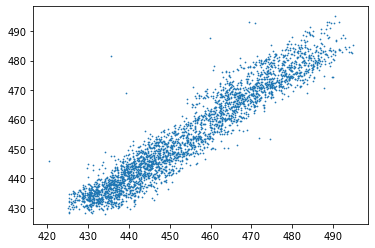

In [10]:
pca = PCA(n_components=3)
pca.fit(X_test)
x_te_pca = pca.fit_transform(X_test)
x_te_pca=torch.from_numpy(x_te_pca)
y_test_model=model_pca(x_te_pca)
y_predict=y_test_model.detach().numpy()
plt.scatter(y_test,y_predict,s=0.5)
r=r2_score(y_test,y_predict)
print(r)
MSE_ANN = mean_squared_error(y_test,y_predict)
print('MSE is %s'%MSE_ANN)

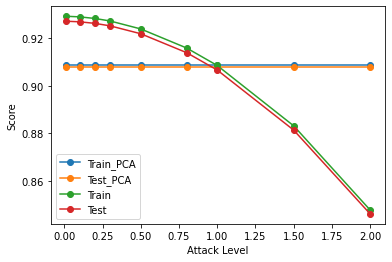

In [11]:
train_scores_lasso_pca = []
test_scores_lasso_pca = []

pca = PCA(n_components=3)

levels = [0.01,0.10, 0.20, 0.30, 0.50, 0.8, 1.00, 1.5, 2.0]
for level in levels:
    X_attack = X + sign * level
    X_attack_standard = scaler.fit_transform(X_attack)
    pca.fit(X_attack_standard)
    X_attack_pca = pca.fit_transform(X_attack_standard)
    X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(X_attack_pca, y, test_size=0.33, random_state=42)
   
    
    train_scores_lasso_pca.append(r2_score(model_pca(torch.from_numpy(X_train_adv)).detach().numpy(),y_train_adv))
    test_scores_lasso_pca.append(r2_score(model_pca(torch.from_numpy(X_test_adv)).detach().numpy(),y_test_adv))
    
plt.plot(levels, train_scores_lasso_pca, label="Train_PCA", marker='o');
plt.plot(levels, test_scores_lasso_pca, label="Test_PCA", marker='o');
plt.plot(levels, train_scores_lasso, label="Train", marker='o');
plt.plot(levels, test_scores_lasso, label="Test", marker='o');
plt.xlabel("Attack Level");
plt.ylabel("Score");
plt.legend();

# Ridge regression

In [12]:
#data_PE=data_PE.T
X_train, X_test, y_train, y_test = train_test_split(data, data_PE, test_size=0.33)

ridge = Ridge(alpha = 1)
ridge.fit(X_train, y_train)
print(ridge.score(X_train, y_train))
print(ridge.score(X_test, y_test))

0.9284005320020625
0.9291705537939929


Text(0.5, 1.0, 'Ridge Regression')

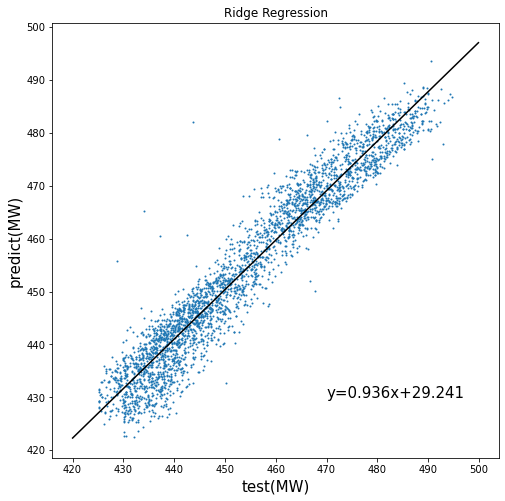

In [13]:
predict = ridge.predict(X_test)
n=len(predict)

t = np.linspace(1,n,n)
plt.figure(figsize=(8,8))
plt.xlabel('test(MW)',fontsize=15)
plt.ylabel('predict(MW)',fontsize=15)
plt.scatter(y_test,predict,s=1)
z5 = np.polyfit(y_test,predict,1)  #Linear fitting
x5 = np.arange(420, 500, 0.1)
y5 = x5 * z5[0]+z5[1]
plt.plot(x5, y5,'black')
plt.text(470,430,'y=%.3fx+%.3f'%(z5[0],z5[1]),fontsize=15)
plt.title('Ridge Regression')

# FGS attack on Ridge Regression

![Ridge](./Ridge1.png)

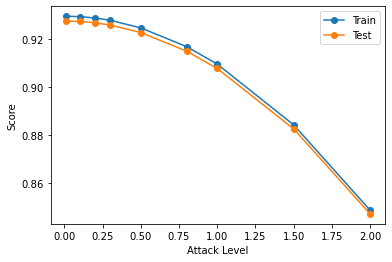

In [14]:

theta = ridge.coef_
theta_ridge = theta
grad = (X@theta-y).reshape(-1,1)*theta.reshape(1,-1)
sign = np.sign(grad)

train_scores_ridge = []
test_scores_ridge = []
levels = [0.01,0.10, 0.20, 0.30, 0.50, 0.8, 1.00, 1.5, 2.0]
for level in levels:
    X_attack = X + sign * level
    X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge = train_test_split(X_attack, y, test_size=0.33, random_state=42)
    train_scores_ridge.append(ridge.score(X_train_ridge, y_train_ridge))
    test_scores_ridge.append(ridge.score(X_test_ridge, y_test_ridge))

plt.plot(levels, train_scores_ridge, label="Train", marker='o');
plt.plot(levels, test_scores_ridge, label="Test", marker='o');
plt.xlabel("Attack Level");
plt.ylabel("Score");
plt.legend();

# PCA defense

Text(0.5, 1.0, 'PCA defense for Ridge Regression')

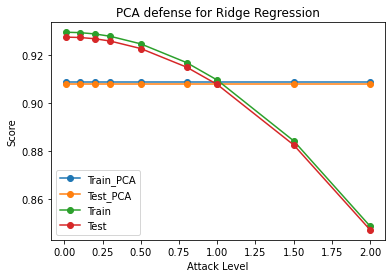

In [15]:
train_scores_ridge_pca = []
test_scores_ridge_pca = []

pca = PCA(n_components=3)

levels = [0.01,0.10, 0.20, 0.30, 0.50, 0.8, 1.00, 1.5, 2.0]
for level in levels:
    X_attack = X + sign * level
    X_attack_standard = scaler.fit_transform(X_attack)
    pca.fit(X_attack_standard)
    X_attack_pca = pca.fit_transform(X_attack_standard)
    X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(X_attack_pca, y, test_size=0.33, random_state=42)
   
    
    train_scores_ridge_pca.append(r2_score(model_pca(torch.from_numpy(X_train_adv)).detach().numpy(),y_train_adv))
    test_scores_ridge_pca.append(r2_score(model_pca(torch.from_numpy(X_test_adv)).detach().numpy(),y_test_adv))
    
plt.plot(levels, train_scores_ridge_pca, label="Train_PCA", marker='o');
plt.plot(levels, test_scores_ridge_pca, label="Test_PCA", marker='o');
plt.plot(levels, train_scores_ridge, label="Train", marker='o');
plt.plot(levels, test_scores_ridge, label="Test", marker='o');
plt.xlabel("Attack Level");
plt.ylabel("Score");
plt.legend();
plt.title("PCA defense for Ridge Regression")

In [16]:
print(train_scores_ridge_pca)
print(train_scores_lasso_pca)

[0.9086427007710283, 0.908642700771028, 0.908642700771028, 0.9086427007710284, 0.9086427007710282, 0.9086427007710283, 0.9086427007710285, 0.908642700771028, 0.9086427007710283]
[0.9086427007710282, 0.9086427007710283, 0.908642700771028, 0.908642700771028, 0.9086427007710283, 0.9086427007710285, 0.9086427007710282, 0.9086427007710283, 0.9086427007710283]


In [17]:
print(theta_lasso)
print(theta_ridge)

[-1.97690176 -0.23316182  0.05421816 -0.15293026]
[-1.97408614 -0.23587719  0.07253142 -0.15684199]


# K-means Cluster

In [18]:
scaler = StandardScaler()
data_standard = scaler.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(data_standard, data_PE, test_size=0.02)

n = 8 #number of clusters
km_cluster = KMeans(n_clusters=n, max_iter=20000, n_init=40,init='k-means++')

km_cluster.fit(X_train)
results = km_cluster.predict(X_test)
label_pred = km_cluster.labels_ 
centroids = km_cluster.cluster_centers_ 
inertia = km_cluster.inertia_ 

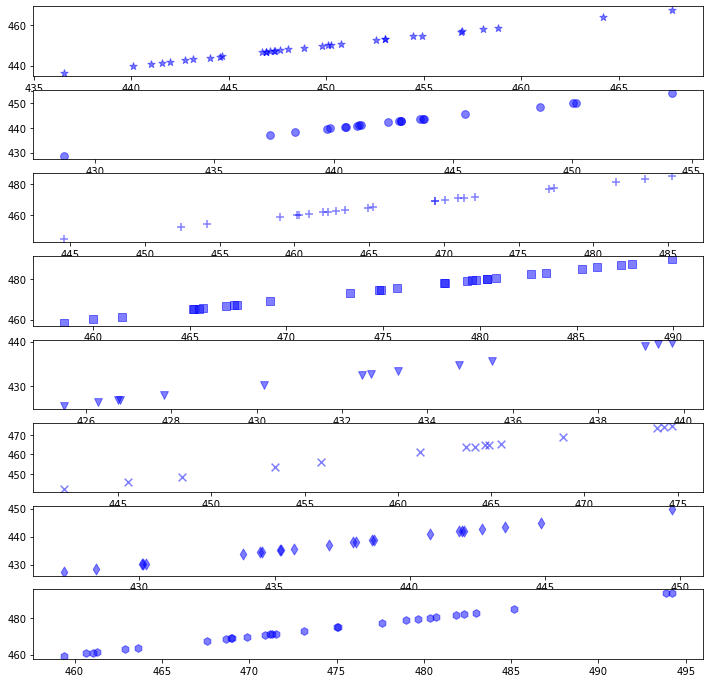

In [19]:
markers = ['*','o','+','s','v','x','d','h']
color = ['r','c','m','g','b','black','orange','lime']

plt.figure(figsize=(12,12))
for i in range(n):
    members = results == i
    plt.subplot(n,1,i+1)
    plt.scatter(y_test[members],y_test[members],s = 60,marker = markers[i],c = 'b',alpha=0.5)